In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
def read(myname):
    df=pd.read_parquet(myname, engine='pyarrow')
    df['timestamp']=pd.to_datetime(df['exch_ts'], unit='ns')
    df.set_index('timestamp', inplace=True)
    return df

In [10]:
def get_price(df,myside,mytype):
    price = df[df['side'] == myside]['price'].resample('20ms').mean()
    if (myside==-1):
        myside='_bid'
    else:
        myside='_ask'
    price.rename('price_'+str(mytype)+str(myside),inplace=True)
    return price.interpolate()

In [11]:
df_fut=read('trades_fut.parquet')
df_fut1=pd.DataFrame(get_price(df_fut,1,'fut'))
df_futm1=pd.DataFrame(get_price(df_fut,-1,'fut'))

df_spt=read('trades_spt.parquet')
df_spt1=pd.DataFrame(get_price(df_spt,1,'spt'))
df_sptm1=pd.DataFrame(get_price(df_spt,-1,'spt'))


In [15]:
df_fut_mearged=pd.merge(df_fut1,df_futm1,on='timestamp',how='inner')
df_spt_mearged=pd.merge(df_spt1,df_sptm1,on='timestamp',how='inner')
df=pd.merge(df_fut_mearged,df_spt_mearged,on='timestamp',how='inner')

In [19]:
df.head(5)

,price_fut_ask,price_fut_bid,price_spt_ask,price_spt_bid
timestamp,,,,
2021-04-01 00:00:01.100,1923.07,1922.884242,1919.38,1919.370000
2021-04-01 00:00:01.120,1923.07,1922.888529,1919.38,1919.374118
2021-04-01 00:00:01.140,1923.07,1922.892816,1919.38,1919.378235
2021-04-01 00:00:01.160,1923.07,1922.897103,1919.38,1919.382353
2021-04-01 00:00:01.180,1923.07,1922.901390,1919.38,1919.386471


/Users/aleksandra/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


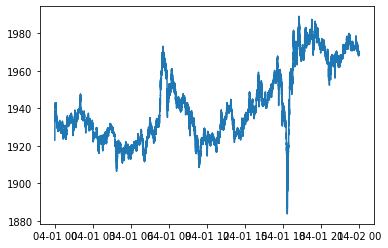

In [20]:
plt.plot(df['price_fut_ask'])

In [21]:
df['fut_mid_price']=0.5 * (df['price_fut_ask']+df['price_fut_bid'])
df['spt_mid_price']=0.5 * (df['price_spt_ask']+df['price_spt_bid'])
df['mid_fut/mid_spt']=df['fut_mid_price']/df['spt_mid_price']
df=df.rolling(10000).mean().bfill()
df.head(5)

,price_fut_ask,price_fut_bid,price_spt_ask,price_spt_bid,fut_mid_price,spt_mid_price,mid_fut/mid_spt
timestamp,,,,,,,
2021-04-01 00:00:01.100,1935.853714,1935.782513,1931.42101,1931.235465,1935.818114,1931.328237,1.002324
2021-04-01 00:00:01.120,1935.853714,1935.782513,1931.42101,1931.235465,1935.818114,1931.328237,1.002324
2021-04-01 00:00:01.140,1935.853714,1935.782513,1931.42101,1931.235465,1935.818114,1931.328237,1.002324
2021-04-01 00:00:01.160,1935.853714,1935.782513,1931.42101,1931.235465,1935.818114,1931.328237,1.002324
2021-04-01 00:00:01.180,1935.853714,1935.782513,1931.42101,1931.235465,1935.818114,1931.328237,1.002324


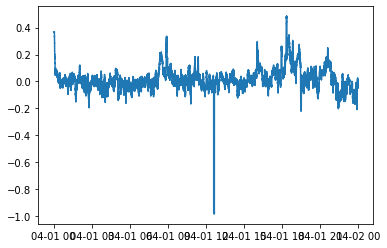

In [22]:
spread=2*(df['price_fut_ask']-df['price_fut_bid'])/(df['price_fut_ask']+df['price_fut_bid'])*10000
plt.plot(spread)

In [37]:
k=1.0012
alpha=1*1e-3
beta=1e-5
df['here_greater']=(df['mid_fut/mid_spt'] > (k+alpha)).shift(1)
df['here_greater'].fillna(False,inplace=True)
df['here_greater']=df['here_greater'].astype(int)

df['here_less']=(df['mid_fut/mid_spt'] < (k-alpha)).shift(1)
df['here_less'].fillna(False,inplace=True)
df['here_less']=df['here_less'].astype(int)

df['here_greater_beta']=(df['mid_fut/mid_spt'] > (k-beta)).shift(1)
df['here_greater_beta'].fillna(False,inplace=True)
df['here_greater_beta']=df['here_greater_beta'].astype(int)

df['here_less_beta']=(df['mid_fut/mid_spt'] < (k+beta)).shift(1)
df['here_less_beta'].fillna(False,inplace=True)
df['here_less_beta']=df['here_less_beta'].astype(int)

df['here_zakrutie']=(df['here_less_beta']*df['here_greater_beta']).shift(1)
df['here_zakrutie'].fillna(0,inplace=True)
df['here_zakrutie']=df['here_zakrutie'].astype(int)


#df['spread']=2*(df['fut_ask']-df['fut_bid'])/(df['fut_ask']+df['fut_bid'])*10000

df['here_last_zakrutie']=np.arange(len(df))*df['here_zakrutie']
df['here_last_zakrutie']=df['here_last_zakrutie'].replace({0:np.nan}).ffill()
df['here_last_zakrutie']=df['here_last_zakrutie'].fillna(0).astype(int)


df['neprav_tek_amt_of_fut']=(-df['here_greater']+df['here_less']).cumsum()
df['neprav_tek_amt_of_spt']=(df['mid_fut/mid_spt']*(df['here_greater']-df['here_less'])).cumsum()


                     
df['tek_amt_of_fut'] = df['neprav_tek_amt_of_fut'] - df['neprav_tek_amt_of_fut'].values[df['here_last_zakrutie']]
df['tek_amt_of_spt'] = df['neprav_tek_amt_of_spt'] - df['neprav_tek_amt_of_spt'].values[df['here_last_zakrutie']]
                   
df['prev_tek_amt_of_fut']=df['tek_amt_of_fut'].shift(1,fill_value=0)
df['prev_tek_amt_of_spt']=df['tek_amt_of_spt'].shift(1,fill_value=0)
    
df['if_tek_amt_of_fut_posit']=(df['tek_amt_of_fut'] >0).astype(int)
df['if_tek_amt_of_spt_posit']=(df['tek_amt_of_spt'] >0).astype(int)



money_change_per_moment=df['here_greater']*((1)*df['price_fut_bid']-df['mid_fut/mid_spt'].shift(1,fill_value=0)*df['price_spt_ask'])+\
                        df['here_less']*((-1)*df['price_fut_ask']+df['mid_fut/mid_spt'].shift(1,fill_value=0)*df['price_spt_bid'])+\
                        df['here_zakrutie']*df['prev_tek_amt_of_fut']*((df['if_tek_amt_of_fut_posit']*df['price_fut_bid']+(1-df['if_tek_amt_of_fut_posit'])*df['price_fut_ask']))+\
                        df['here_zakrutie']*df['prev_tek_amt_of_spt']*((df['if_tek_amt_of_spt_posit']*df['price_spt_bid']+(1-df['if_tek_amt_of_spt_posit'])*df['price_spt_ask']))


money_change_via_zakrutie_per_moment=\
                        df['here_zakrutie']*df['prev_tek_amt_of_fut']*((df['if_tek_amt_of_fut_posit']*df['price_fut_bid']+(1-df['if_tek_amt_of_fut_posit'])*df['price_fut_ask']))+\
                        df['here_zakrutie']*df['prev_tek_amt_of_spt']*((df['if_tek_amt_of_spt_posit']*df['price_spt_bid']+(1-df['if_tek_amt_of_spt_posit'])*df['price_spt_ask']))






value_of_inventer_trajectory=df['tek_amt_of_fut']*df['fut_mid_price']+df['tek_amt_of_spt']*df['spt_mid_price']


pnl_trajectory=money_change_per_moment.cumsum()+value_of_inventer_trajectory



In [38]:
pnl_trajectory[0:5]

timestamp
2021-04-01 00:00:01.100    0.000000
2021-04-01 00:00:01.120   -0.128589
2021-04-01 00:00:01.140   -0.257178
2021-04-01 00:00:01.160   -0.385767
2021-04-01 00:00:01.180   -0.514356
dtype: float64

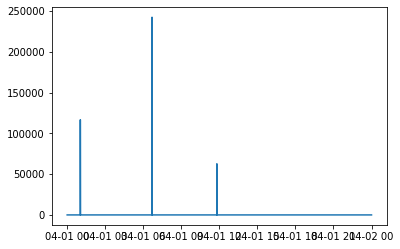

In [39]:
plt.plot(money_change_via_zakrutie_per_moment)

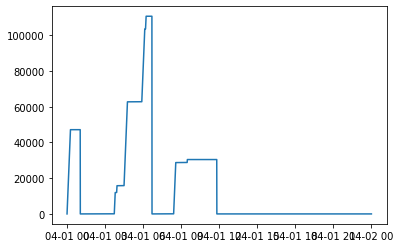

In [40]:
plt.plot(df.index,df['tek_amt_of_spt'])

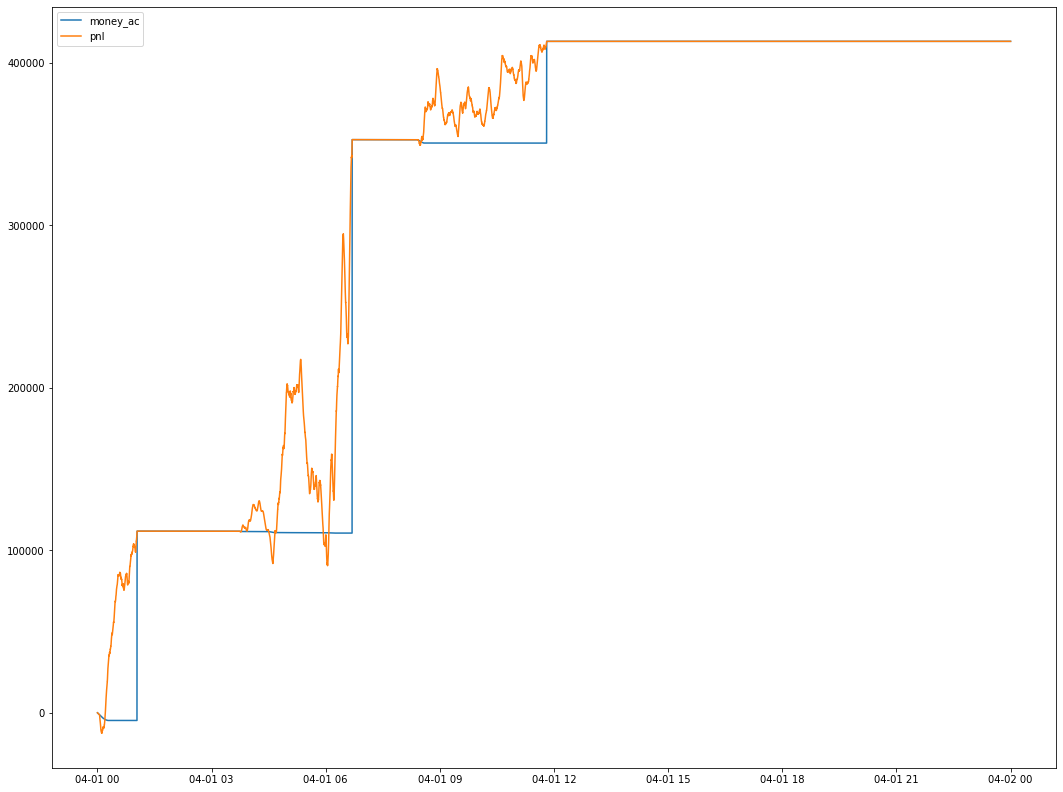

In [32]:
plt.figure(figsize=(18,14))
plt.plot(money_change_per_moment.cumsum(),label='money_ac')
plt.plot(pnl_trajectory,label='pnl')
plt.legend()
plt.show()

In [ ]:
А это старый График (от Руслана)

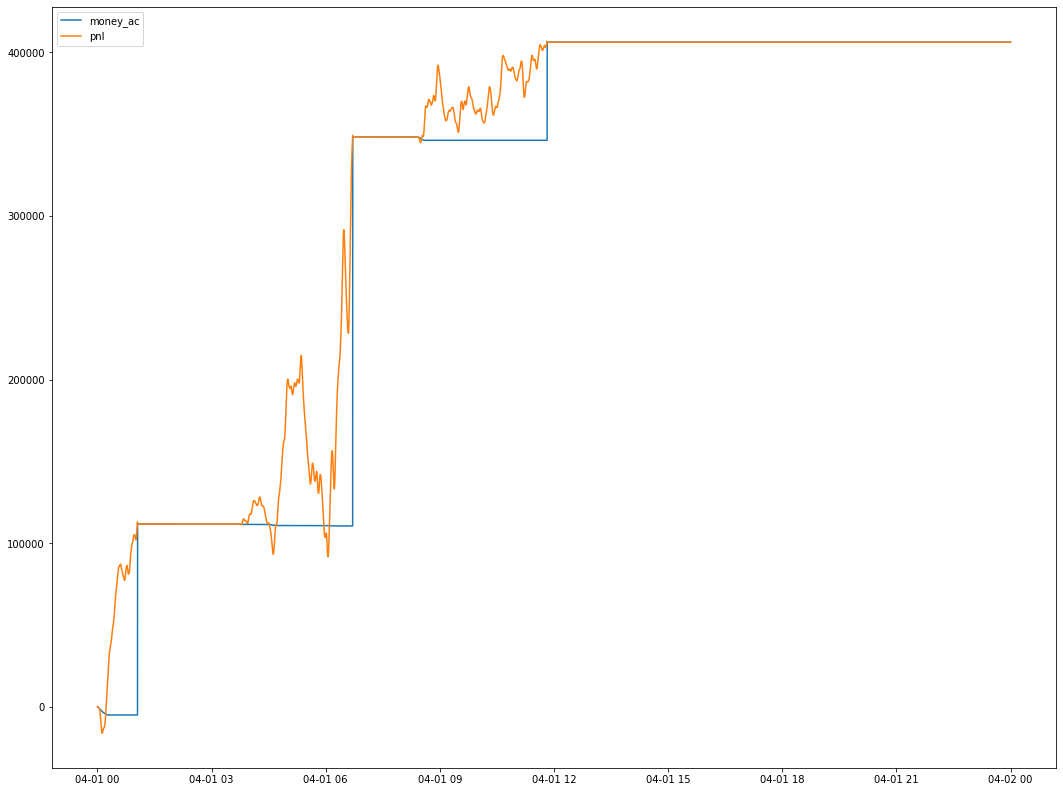

In [76]:
plt.figure(figsize=(18,14))
plt.plot(money_change_per_moment.cumsum(),label='money_ac')
plt.plot(pnl_trajectory,label='pnl')
plt.legend()
plt.show()

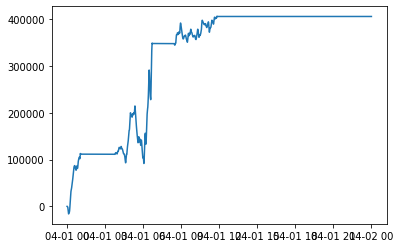

In [77]:
plt.plot(pnl_trajectory)

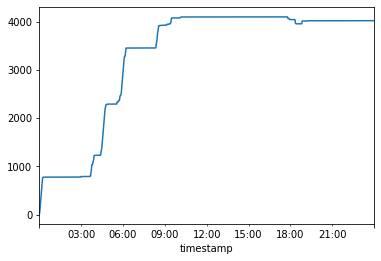

In [88]:
df['tek_amt_of_fut'].plot()

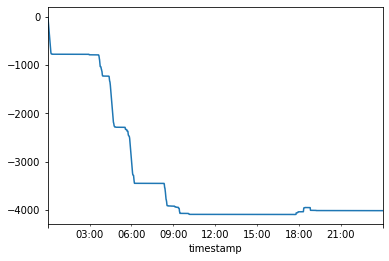

In [89]:
df['tek_amt_of_spt'].plot()

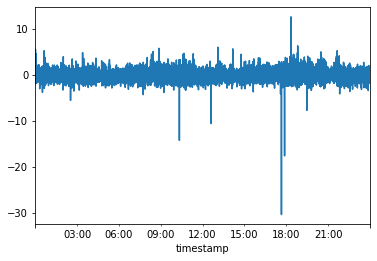

In [71]:
df.spread.plot()

In [5]:
import numpy as np
mas=np.array([1,2,3])

In [6]:
mas

array([1, 2, 3])

In [7]:
mas.shift(1)

AttributeError: 'numpy.ndarray' object has no attribute 'shift'